<a href="https://colab.research.google.com/github/Hamzeluie/GANs/blob/main/GANs/DataAugmentation/cifar100_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import libraries

In [90]:
import os
from os import system
from collections import OrderedDict

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torchvision.models.vgg import vgg16
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm

#Set Parameters

In [112]:
batch_size = 128
classification_epochs = 5
gan_epochs = 10000
n_class = 100
device = "cuda"
classification_save_load_path = "./exp1"
gen_save_load_path = "./gen_exp1"
z_dim = 64

#Set Data

In [ ]:
from torchvision.transforms import transforms
transform = transforms.Compose([
                                # transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
cifar_train = CIFAR100(".", download=True, transform=transform)
cifar_test = CIFAR100(".", download=True, train=False, transform=transform)
train_dataloader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, drop_last=True )
test_dataloader = DataLoader(cifar_test, batch_size=batch_size, shuffle=True, drop_last=True)

#Defining Models

In [114]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.model = nn.Sequential(self.make_gen_block(self.z_dim, hidden_dim * 4, kernel=4),
                                   self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel=4, stride=1),
                                   self.make_gen_block(hidden_dim * 2, hidden_dim, kernel=4),
                                   self.make_gen_block(hidden_dim, img_dim, kernel=2, is_final=True),)

    def make_gen_block(self, in_channel, out_channel, kernel=3, stride=2, is_final=False):
        if is_final:
            return nn.Sequential(nn.ConvTranspose2d(in_channels=in_channel, out_channels=out_channel,
                                                    kernel_size=kernel,
                                                    stride=stride),
                                 nn.Tanh())
        else:
            return nn.Sequential(nn.ConvTranspose2d(in_channels=in_channel, out_channels=out_channel,
                                                    kernel_size=kernel,
                                                    stride=stride),
                                 nn.BatchNorm2d(out_channel),
                                 nn.ReLU(inplace=True))

    def forward(self, x):
        x = x.view(len(x), self.z_dim, 1, 1)
        return self.model(x)
    

class Discriminator(nn.Module):
    def __init__(self, img_dim=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(self.make_disc_block(img_dim, hidden_dim, stride=1),
                                   self.make_disc_block(hidden_dim, hidden_dim * 2),
                                   self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
                                   self.make_disc_block(hidden_dim * 4, 1, is_final=True),
                                   )

    def make_disc_block(self, in_channel, out_channel, kernel=4, stride=2, is_final=False):
        if is_final:
            return nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=kernel, stride=stride)
            )
        else:
            return nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=kernel, stride=stride),
                                 nn.BatchNorm2d(out_channel),
                                 nn.LeakyReLU(.2, inplace=True))

    def forward(self, x):
        return self.model(x).view(len(x), -1)

In [94]:
class Classifier(nn.Module):
    def __init__(self, n_class):
        super(Classifier, self).__init__()
        self.vgg = vgg16(pretrained=True)
        for param in self.vgg.features.parameters():
            param.requires_grad = False
        classifier = self.vgg.classifier[:-1]
        input_channel = classifier[-3].out_features
        classifier.append(nn.Linear(input_channel, n_class))
        self.vgg.classifier = classifier

    def forward(self, x):
        return self.vgg(x)

#Defining Tools for Show image, Save/Load, weight initialization and Evaluaiton

In [96]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [97]:
class Logger:
    def __init__(self, best_param_name: str = "", path_log_dir: str = "."):
        assert type(best_param_name) == str
        assert type(path_log_dir) == str
        self.best_param_name = best_param_name
        self.best_param_val = 0.
        self.last_param_val = 0.
        self.log_path_dir = path_log_dir + "/log.txt"
        self.best_path_dir = path_log_dir + "/best.pth"
        self.last_path_dir = path_log_dir + "/last.pth"
        self.loaded = None
        if os.path.isdir(path_log_dir):
            if os.path.isfile(self.last_path_dir):
                self.last_chp = torch.load(self.last_path_dir)
                self.last_acc = self.last_chp["acc"]
            if os.path.isfile(self.best_path_dir):
                self.best_chp = torch.load(self.best_path_dir)
                self.best_acc = self.best_chp["acc"]

    def save(self, logger_keys: list = [], **kwargs: dict):
        save_dict = {}
        for k, v in kwargs.items():
            save_dict[k] = v
        assert self.best_param_name in save_dict.keys() or self.best_param_name == "", "best_param_name  should be in kwargs or ''"
        assert type(logger_keys) == list
        if len(logger_keys) == 0:
            log_flg = False
        else:
            log_flg = True
            for i in logger_keys:
                assert type(i) == str and i in save_dict.keys(), "logger_keys should match to kwargs"

        try:
            if log_flg:
                with open(self.log_path_dir, "a") as f:
                    for k in logger_keys:
                        f.write(k + " " + str(save_dict[k]))
                        f.write("\n")
                f.close()

            torch.save(save_dict, self.last_path_dir)
            print(f"last check_point saved at {self.last_path_dir}")

            if self.best_param_name != "":
                if self.best_param_val < save_dict[self.best_param_name]:
                    torch.save(save_dict, self.best_path_dir)
                    self.best_param_val = save_dict[self.best_param_name]
                    print(f"this is best till now, saved at {self.best_path_dir}")

        except RuntimeError:
            file_name = self.last_path_dir.split("/")[-1]
            print(f"directory '{self.last_path_dir[:-(file_name.__len__() + 1)]}' is not exist")

    def show_logger(self, out_put_list: list = []):
        assert type(out_put_list) == list
        status = {}
        if len(out_put_list) > 0:
            for obj_name in out_put_list:
                assert obj_name in self.loaded.keys(), f"should first use load_state_dicts or " \
                                                       f"{obj_name} is not in file that loaded"
                status[obj_name] = self.loaded[obj_name]
            print(status.items())

    def load_state_dicts(self, mode: str = "last", **kwargs):
        dict_objects_state_dict = {}
        for k, v in kwargs.items():
            dict_objects_state_dict[k] = v
        if mode == "last":
            path = self.last_path_dir
        elif mode == "best":
            path = self.best_path_dir

        try:
            self.loaded = torch.load(path)
            print("loaded items :", self.loaded.keys())
            for obj in dict_objects_state_dict.keys():
                assert obj in self.loaded.keys(), f"{obj} not founded"
                dict_objects_state_dict[obj].load_state_dict(self.loaded[obj])
                print(f"{obj} loaded")

        except FileNotFoundError:
            print(f"there is no file {path}")
        except AttributeError:
            print("inputs type are not use properly.")
        except NameError:
            print(f"mode should be 'last' or 'best' but is '{mode}'")

In [98]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [99]:
def classifier_evaluation(model, criterion, val_dataloader):
    print(f"evaluation steps number {len(val_dataloader)}")
    classifier_correct = 0
    num_validation = 0
    classifier_val_loss = 0
    for img, lbl in val_dataloader:
        img = img.to(device)
        lbl = lbl.to(device)
        cur_batch_size = len(img)
        num_validation += cur_batch_size
        pred = model(img)
        classifier_val_loss += criterion(pred, lbl) * cur_batch_size
        classifier_correct += (pred.argmax(1) == lbl).float().sum()
    loss = classifier_val_loss.item() / num_validation
    acc = classifier_correct.item() / num_validation
    print(f"Test loss: {round(loss, 3)},"
    f"accuracy: {round(acc, 3)}")
    return loss, acc

In [100]:
def get_noise(b, z_dim):
    return torch.randn(b, z_dim)

#Training

## Train Classifier

In [ ]:
status_step = 5
save_step = 1
logger = Logger(path_log_dir=classification_save_load_path)

classifier = Classifier(n_class).to(device)
# classifier.apply(weights_init)
opt = torch.optim.Adam(classifier.parameters())
logger.load(classifier, opt, "best")
scheduler = CosineAnnealingLR(opt, 200, verbose=False)
criterion = nn.CrossEntropyLoss()
losses = []
for e in range(classification_epochs):
    classifier_train_loss = 0
    classifier_correct = 0
    num_samples = 0
    for idx, (img, lbl) in enumerate(tqdm(train_dataloader)):
        img = img.to(device)
        lbl = lbl.to(device)
        cur_batch_size = len(img)
        num_samples += cur_batch_size
        opt.zero_grad()
        pred = classifier(img)
        classifier_loss = criterion(pred, lbl)
        classifier_loss.backward()
        classifier_train_loss += classifier_loss.item()
        opt.step()
        classifier_correct += (pred.argmax(1) == lbl).float().sum()
        if idx % status_step == 0:
            scheduler.step()
            print(f"Epoch {e + 1}/{classification_epochs} step/samples {idx}/{len(train_dataloader)} Training"
                      f" loss: {round(classifier_train_loss / num_samples, 3)}"
                      f" Accuracy: {round(classifier_correct.item() / num_samples, 3)}"
                      f", lr={round(opt.param_groups[-1]['lr'], 6)}")
            classifier_train_loss = 0
            classifier_correct = 0
            num_samples = 0
    eval_loss, eval_acc = classifier_evaluation(classifier, criterion, test_dataloader)
    logger.save(eval_loss, eval_acc, classifier.state_dict(), opt.state_dict(), idx)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1/5 step/samples 0/2500 Training loss: 0.122 Accuracy: 0.1, lr=0.001
Epoch 1/5 step/samples 5/2500 Training loss: 0.126 Accuracy: 0.3, lr=0.000998
Epoch 1/5 step/samples 10/2500 Training loss: 0.116 Accuracy: 0.29, lr=0.000993
Epoch 1/5 step/samples 15/2500 Training loss: 0.099 Accuracy: 0.41, lr=0.000984
Epoch 1/5 step/samples 20/2500 Training loss: 0.096 Accuracy: 0.52, lr=0.000973
Epoch 1/5 step/samples 25/2500 Training loss: 0.072 Accuracy: 0.5, lr=0.000959
Epoch 1/5 step/samples 30/2500 Training loss: 0.065 Accuracy: 0.55, lr=0.000942
Epoch 1/5 step/samples 35/2500 Training loss: 0.06 Accuracy: 0.58, lr=0.000922
Epoch 1/5 step/samples 40/2500 Training loss: 0.059 Accuracy: 0.62, lr=0.0009
Epoch 1/5 step/samples 45/2500 Training loss: 0.057 Accuracy: 0.65, lr=0.000875
Epoch 1/5 step/samples 50/2500 Training loss: 0.084 Accuracy: 0.56, lr=0.000848
Epoch 1/5 step/samples 55/2500 Training loss: 0.064 Accuracy: 0.62, lr=0.000819
Epoch 1/5 step/samples 60/2500 Training loss: 0.047

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2/5 step/samples 0/2500 Training loss: 0.02 Accuracy: 0.9, lr=0.000492
Epoch 2/5 step/samples 5/2500 Training loss: 0.03 Accuracy: 0.82, lr=0.000453
Epoch 2/5 step/samples 10/2500 Training loss: 0.027 Accuracy: 0.8, lr=0.000414
Epoch 2/5 step/samples 15/2500 Training loss: 0.028 Accuracy: 0.84, lr=0.000376
Epoch 2/5 step/samples 20/2500 Training loss: 0.026 Accuracy: 0.86, lr=0.000338
Epoch 2/5 step/samples 25/2500 Training loss: 0.032 Accuracy: 0.79, lr=0.000301
Epoch 2/5 step/samples 30/2500 Training loss: 0.026 Accuracy: 0.87, lr=0.000266
Epoch 2/5 step/samples 35/2500 Training loss: 0.046 Accuracy: 0.77, lr=0.000232
Epoch 2/5 step/samples 40/2500 Training loss: 0.029 Accuracy: 0.78, lr=0.0002
Epoch 2/5 step/samples 45/2500 Training loss: 0.031 Accuracy: 0.83, lr=0.000169
Epoch 2/5 step/samples 50/2500 Training loss: 0.027 Accuracy: 0.86, lr=0.000141
Epoch 2/5 step/samples 55/2500 Training loss: 0.026 Accuracy: 0.82, lr=0.000115
Epoch 2/5 step/samples 60/2500 Training loss: 0.

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3/5 step/samples 0/2500 Training loss: 0.013 Accuracy: 0.95, lr=0.0
Epoch 3/5 step/samples 5/2500 Training loss: 0.024 Accuracy: 0.91, lr=2e-06
Epoch 3/5 step/samples 10/2500 Training loss: 0.024 Accuracy: 0.89, lr=7e-06
Epoch 3/5 step/samples 15/2500 Training loss: 0.021 Accuracy: 0.82, lr=1.6e-05
Epoch 3/5 step/samples 20/2500 Training loss: 0.032 Accuracy: 0.79, lr=2.7e-05
Epoch 3/5 step/samples 25/2500 Training loss: 0.028 Accuracy: 0.79, lr=4.1e-05
Epoch 3/5 step/samples 30/2500 Training loss: 0.023 Accuracy: 0.86, lr=5.8e-05
Epoch 3/5 step/samples 35/2500 Training loss: 0.023 Accuracy: 0.89, lr=7.8e-05
Epoch 3/5 step/samples 40/2500 Training loss: 0.021 Accuracy: 0.9, lr=0.0001
Epoch 3/5 step/samples 45/2500 Training loss: 0.026 Accuracy: 0.82, lr=0.000125
Epoch 3/5 step/samples 50/2500 Training loss: 0.031 Accuracy: 0.8, lr=0.000152
Epoch 3/5 step/samples 55/2500 Training loss: 0.033 Accuracy: 0.81, lr=0.000181
Epoch 3/5 step/samples 60/2500 Training loss: 0.02 Accuracy: 0

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4/5 step/samples 0/2500 Training loss: 0.007 Accuracy: 0.95, lr=0.000508
Epoch 4/5 step/samples 5/2500 Training loss: 0.015 Accuracy: 0.88, lr=0.000547
Epoch 4/5 step/samples 10/2500 Training loss: 0.016 Accuracy: 0.88, lr=0.000586
Epoch 4/5 step/samples 15/2500 Training loss: 0.013 Accuracy: 0.92, lr=0.000624
Epoch 4/5 step/samples 20/2500 Training loss: 0.032 Accuracy: 0.85, lr=0.000662
Epoch 4/5 step/samples 25/2500 Training loss: 0.03 Accuracy: 0.8, lr=0.000699
Epoch 4/5 step/samples 30/2500 Training loss: 0.019 Accuracy: 0.89, lr=0.000734
Epoch 4/5 step/samples 35/2500 Training loss: 0.018 Accuracy: 0.87, lr=0.000768
Epoch 4/5 step/samples 40/2500 Training loss: 0.011 Accuracy: 0.93, lr=0.0008
Epoch 4/5 step/samples 45/2500 Training loss: 0.016 Accuracy: 0.91, lr=0.000831
Epoch 4/5 step/samples 50/2500 Training loss: 0.021 Accuracy: 0.85, lr=0.000859
Epoch 4/5 step/samples 55/2500 Training loss: 0.025 Accuracy: 0.84, lr=0.000885
Epoch 4/5 step/samples 60/2500 Training loss: 

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 5/5 step/samples 0/2500 Training loss: 0.03 Accuracy: 0.8, lr=0.001
Epoch 5/5 step/samples 5/2500 Training loss: 0.025 Accuracy: 0.9, lr=0.000998
Epoch 5/5 step/samples 10/2500 Training loss: 0.038 Accuracy: 0.86, lr=0.000993
Epoch 5/5 step/samples 15/2500 Training loss: 0.037 Accuracy: 0.82, lr=0.000984
Epoch 5/5 step/samples 20/2500 Training loss: 0.02 Accuracy: 0.86, lr=0.000973
Epoch 5/5 step/samples 25/2500 Training loss: 0.052 Accuracy: 0.83, lr=0.000959
Epoch 5/5 step/samples 30/2500 Training loss: 0.058 Accuracy: 0.79, lr=0.000942
Epoch 5/5 step/samples 35/2500 Training loss: 0.029 Accuracy: 0.83, lr=0.000922
Epoch 5/5 step/samples 40/2500 Training loss: 0.029 Accuracy: 0.84, lr=0.0009
Epoch 5/5 step/samples 45/2500 Training loss: 0.027 Accuracy: 0.86, lr=0.000875
Epoch 5/5 step/samples 50/2500 Training loss: 0.046 Accuracy: 0.79, lr=0.000848
Epoch 5/5 step/samples 55/2500 Training loss: 0.025 Accuracy: 0.86, lr=0.000819
Epoch 5/5 step/samples 60/2500 Training loss: 0.047

## Train Gan

In [ ]:
status_step = 5
save_step = 1
logger = Logger(path_log_dir=gen_save_load_path)

gen = Generator(z_dim + n_class).to(device)
disc = Discriminator(3 + n_class).to(device)
opt_gen = torch.optim.Adam(gen.parameters())
opt_disc = torch.optim.Adam(disc.parameters())

schedual_gen = CosineAnnealingLR(opt_gen, 200, verbose=False)
schedual_disc = CosineAnnealingLR(opt_disc, 200, verbose=False)

criterion = nn.BCEWithLogitsLoss()
for e in range(gan_epochs):
    disc_train_loss = 0
    gen_train_loss = 0
    num_samples = 0
    for idx, (real, trgt) in enumerate(tqdm(train_dataloader)):
        real = real.to(device)
        trgt = trgt.to(device)
        b, c, w, h = real.shape
        num_samples += b
        # discriminator
        opt_disc.zero_grad()
        one_hot_trgt = nn.functional.one_hot(trgt, n_class)
        image_one_hot_trgt = one_hot_trgt[:, :, None, None]
        image_one_hot_trgt = image_one_hot_trgt.repeat(1, 1, w, h)

        noise = get_noise(b, z_dim).to(device)
        fake = torch.cat([noise, one_hot_trgt], 1)

        gen_fake = gen(fake)
        
        fake_image_trgt = torch.cat([gen_fake.detach(), image_one_hot_trgt], 1)
        real_image_trgt = torch.cat([real, image_one_hot_trgt], 1)

        disc_fake = disc(fake_image_trgt)
        disc_real = disc(real_image_trgt)

        fake_disc_loss = criterion(disc_fake, torch.zeros_like(disc_fake))
        real_disc_loss = criterion(disc_real, torch.ones_like(disc_real))

        disc_loss = (fake_disc_loss + real_disc_loss)  / 2
        disc_loss.backward(retain_graph=True)
        opt_disc.step()
        schedual_disc.step()
        
        disc_train_loss += disc_loss.item()
        # generator
        opt_gen.zero_grad()
        fake_image_trgt = torch.cat([gen_fake, image_one_hot_trgt], 1)
        disc_pred = disc(fake_image_trgt)
        gen_loss = criterion(disc_pred, torch.ones_like(disc_pred))
        gen_loss.backward()
        opt_gen.step()
        schedual_gen.step()

        gen_train_loss += gen_loss.item()
        if idx % status_step == 0:
            print(f"Epoch {e + 1}/{gan_epochs} step/samples {idx}/{len(train_dataloader)} Training "
            f"Discriminator loss {round(disc_train_loss / num_samples, 3)}"
            f" Generator loss {round(gen_train_loss / num_samples, 3)}")

            show_tensor_images(gen_fake, b, (3, 32, 32))
    
    save_dict = {"opt_gen": opt_gen,
                 "opt_disc": opt_disc,
                 "discriminator": disc,
                 "generator":gen,
                 "disc_loss": disc_train_loss / num_samples,
                 "gen_loss": gen_train_loss / num_samples,
                 "idx": idx}
    logger.save(
        ["disc_loss", "gen_loss"],
        opt_gen= opt_gen,
        opt_disc= opt_disc,
        disc= disc, 
        gen= gen,
        disc_loss= disc_train_loss / num_samples,
        gen_loss=gen_train_loss / num_samples,
        idx=idx
        )
    



# Evaluation

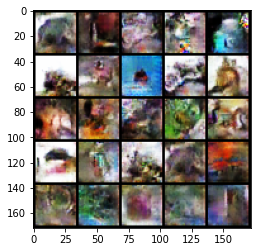

In [127]:
_, lbl = next(iter(test_dataloader))
b = len(lbl)
one_hot_label = nn.functional.one_hot(lbl, n_class)
noise = torch.randn(b, z_dim)
noise_and_lbl = torch.cat([noise, one_hot_label], 1)
pred = gen(noise_and_lbl)
show_tensor_images(pred)
    
